# 基于ResNet50的图像分类

本实验使用ResNet50网络实现医学图像分类任务，分类数据集数据选用花分类的公开数据集。结合课程学习，通过本实验可以了解Resnet50网络结构和图像分类数据集处理相关知识，并且掌握如何使用MindSpore深度学习框架搭建ResNet50网络并且进行训练和验证，最后可视化训练结果。

## 1、ResNet网络介绍

[原论文地址](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

ResNet是2015年由何凯明提出的一个分类网络模型,并在`ImageNet Classification`、`ImageNet Detection`、`ImageNet Localization`、`COCO Detection`、`COCO Segmentation`这五个主要赛道中都获得第一名。

在ResNet网络提出之前，传统的卷积神经网络都是将一系列的卷积层和池化层堆叠得到的，但当网络堆叠到一定深度时，就会出现**退化问题**，如下图所示：

<div align="center">
<img src="./images/层数越多网路出现退化现象.png" width="70%" height="70%">
</div>

左图和右图分别是20层和56层网络在CIFAR-10数据集上的训练误差曲线图及测试误差曲线图，可以清晰地看出，56层网络的训练误差和测试误差更大，而不是如预想中的“误差理应减小”。

### 1.1 残差结构

为了解决上诉的**退化问题**，ResNet网络提出了**残差结构**，其如下图所示：

<div align="center">
<img src="./images/残差结构.png" width="50%" height="50%">
</div>

图中输入`x`，输出为`H(x)=F(x)+x`，此公式可以直观地理解为输出来自两部分，一部分源于输入`x`本身，一部分源于将输入进行一系列非线性变换后的结果`F(x)`。需要网络学习的部分就是`F(x)`，即**只需要学习输入输出差别的那一部分**，简化了学习的目标。

通过将plain network(不加残差结构)和residual network对比分析，发现残差网络在没有添加额外参数量的情况下性能更好，训练误差和测试误差均比plain network更低。

<div align="center">
<img src="./images/plain和residual对比.png" width="70%" height="70%">
</div>

下表对比了18层ResNet和34层plain network的测试误差：

<div align="center">
<img src="./images/不同层数残差网络对比.png" width="50%" height="50%">
</div>

+ 18层的ResNet比18层的plain netwoek性能更好，说明了残差结构的有效性。

+ 34层的ResNet比18层的ResNet的测试误差低，说明了通过残差结构能够很好地解决“**当网络堆叠到一定深度时性能出现退化**”的问题。

### 1.2 残差块

对于18/34层以及50/101/152层网络分别设计了两种残差块，结构图如下：

<div align="center">
<img src="./images/两种残差块设计_修改后.png" width="50%" height="50%">
</div>

左图通过堆叠2个`3×3`卷积层实现残差函数，考虑到训练更深的网络所需付出的训练时间，又设计了一种瓶颈(Bottleneck)结构用于训练ResNet50/101/512，在瓶颈结构中残差函数通过堆叠`1×1`、`3×3`、`1×1`卷积层得以实现，其中`1×1`主要起到调整维数的作用。即使右图结构层数比左图多，但是这两种不同残差块有着相近的时间复杂度，且在输入维度相同的情况下，右图的参数量比左图小。

论文中使用不同深度的ResNet网络在CIFAR-10数据集上的训练误差与测试误差图如下图所示，图中虚线表示训练误差，实线表示测试误差。由图中数据可以看出，ResNet网络层数越深，其训练误差和测试误差越小。

<div align="center">
<img src="./images/ResNet网络不同层的错误率对比.png" width="50%" height="50%">
</div>

但在随后的实验中发现200层的ResNet网络在ImageNet训练上出现了过拟合现象。针对这一现象在后续何凯明的论文[《Identity Mapping in Deep Residual Networks》](https://arxiv.org/abs/1603.05027)中做了进一步的改进，改进后的残差块结构如下图中的右图所示：

<div align="center">
<img src="./images/改进后的残差块.png" width="30%" height="30%">
</div>

将改进前后的残差块在CIFAR-10数据集上进行训练，性能对比分析结果如下图所示：

<div align="center">
<img src="./images/改进前后的残差块性能对比分析.png" width="50%" height="50%">
</div>

### 1.3 Shortcut Connection

残差块中跳跃连接(skip connection)部分都设计为恒等映射，关于跳跃连接这部分的设计作者在[《Identity Mapping in Deep Residual Networks》](https://arxiv.org/abs/1603.05027)中进行了详细的阐述。

通过将恒等映射更换为"scaling"、"gating"、"1×1 convolution"、"dropout"，并做了对比分析，非恒等映射形式引入了更多的参数，这理应使得网络具有更强的拟合能力，但是网络的性能出现了退化，因此退化的原因不是拟合能力的不足，而是优化问题，最终得出结论：**设计为恒等跳跃连接更有利于优化**。

下图展示了不同的跳跃连接方式结构图。

<div align="center">
<img src="./images/shorcutconnection对比分析.png" width="50%" height="50%">
</div>

下表为将不同的跳跃连接方式应用到ResNet-110中，在CIFAR-10测试集上得到的分类误差对比，表中"fail"为测试误差率超过20%。

<div align="center">
<img src="./images/不同跳跃连接测试误差对比表.png" width="70%" height="70%">
</div>

### 1.4 选择实验环境

运行下面代码，在下拉菜单中选择实验环境，目前支持CPU和Ascend NPU切换。

In [1]:
import os
import mindspore
from mindspore import context
import ipywidgets as wgs # 控件

dropdown = wgs.Dropdown(description="Select Device", options=['Click to choose', 'CPU', 'Ascend NPU'])
output = wgs.Output()
def changeDevice(change):
    output.clear_output()
    token = change.new
    with output:
        if token == 'Click to choose':
            print("请选择运行环境")
        if token == 'CPU':
            print("请确认当前环境为CPU\n======================================================================")
            try:
                context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
                print("已检查！确认当前环境为CPU")
            except ValueError:
                print("错误！当前是系统硬件不是CPU，请重新选择合适的硬件设备")
        if token == 'Ascend NPU':
            print("请确认当前环境为Ascend NPU\n===============================================================")
            try:
                context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
                print("当前环境为Ascend NPU")
            except ValueError:
                print("错误！当前是系统硬件不是Ascend NPU，请重新选择合适的硬件设备")

dropdown.observe(changeDevice, names='value')
display(dropdown, output)

Dropdown(description='Select Device', options=('Click to choose', 'CPU', 'Ascend NPU'), value='Click to choose…

Output()

运行下面代码继续完成硬件平台配

In [2]:
mindspore.set_seed(1)
if dropdown.value == 'CPU':
    print("选择的环境是：" + dropdown.value)
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        print("CPU环境设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
    epoch_size = 1
    batch_size = 2
    pre_trained = True
    dataset_sink_mode = False
    save_ckpt_num = 1
    per_print_steps = 200
elif dropdown.value == 'Ascend NPU':
    print("选择的环境是：" + dropdown.value)
    device_id = 0
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
        print("Ascend NPU环境设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持Asend NPU，请返回上一步重新选择合适的硬件设备")
    epoch_size = 90
    batch_size = 16
    pre_trained = False
    dataset_sink_mode = True
    save_ckpt_num = 10    # 每20轮保存一次ckpt文件
    per_print_steps = 206
elif dropdown.value == 'Click to chose':
    print("未手动选择运行环境")
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        print("默认运行为CPU环境，已设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
    epoch_size = 1
    batch_size = 2
    pre_trained = True
    dataset_sink_mode = False
    save_ckpt_num = 1
    per_print_steps = 200
else:
    print("未手动选择运行环境")
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        print("默认运行为CPU环境，已设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
    epoch_size = 1
    batch_size = 2
    pre_trained = True
    dataset_sink_mode = False
    save_ckpt_num = 1
    per_print_steps = 200

选择的环境是：CPU
CPU环境设置成功！


## 2、数据集加载

本次实验采用的是花分类数据集，其共有 3306 张训练图片和 364 张测试图片，和5张用于推理的图片，该数据集涵盖 5 个类别的 RGB 彩色图片：雏菊(daisy)、蒲公英(dandelion)、玫瑰(roses)、向日葵(sunflowers)、郁金香(tulips) 。

```Text
datasets
└── flowers
    ├── infer
    │   ├── daisy.jpg
    │   ├── dandelion.jpg
    │   ├── roses.jpg
    │   ├── sunflowers.jpg
    │   └── tulips.jpg
    ├── train
    │   ├── daisy
    │   ├── dandelion
    │   ├── roses
    │   ├── sunflowers
    │   └── tulips
    └── val
        ├── daisy
        ├── dandelion
        ├── roses
        ├── sunflowers
        └── tulips
```

### 2.1 数据集下载

运行下面代码将数据集下载并解压在notebook所在目录下的dataset文件夹下。

In [3]:
import os
import requests
import time
import zipfile

# 自动下载并解压数据集到指定文件夹内
def download_and_unzip(url, path):
    if not os.path.exists(path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(path)
    file_path = os.path.join(path, 'flowers.zip')
    start = time.time() #下载开始时间
    user, password = 'tyx_neu', 'Sportlab307'
    resp = requests.get(url, auth=(user, password), stream=True)      #把下载地址发送给requests模块
    size = 0    #初始化已下载大小
    chunk_size = 1024  # 每次下载的数据大小
    content_size = int(resp.headers['content-length'])  # 下载文件总大小
    try:
        if resp.status_code == 200:   #判断是否响应成功
            print('Start download,[File size]:{size:.2f} MB'.format(size=content_size/chunk_size/1024))  #开始下载，显示下载文件大小
            with open(file_path, 'wb') as file:   #显示进度条
                for data in resp.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    size += len(data)
                    print('\r'+'[下载进度]:%s%.2f%%' % ('>'*int(size*50/content_size), float(size/content_size*100)), end=' ')
        end = time.time()   #下载结束时间
        print('\n'+'Download completed!,times: %.2f秒' % (end - start))  #输出下载用时时间
    except ValueError:
        print('Error!')
    unzip_file_path = os.path.join(path, './')
    if not os.path.exists(unzip_file_path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(unzip_file_path)
    zip_file = zipfile.ZipFile(file_path)
    zip_list = zip_file.namelist()  # 压缩文件清单，可以直接看到压缩包内的各个文件的明细
    for f in zip_list:  # 遍历这些文件，逐个解压出来，
        zip_file.extract(f, unzip_file_path)
    zip_file.close()
    print('Successfully unzip download dataset from website!')

#下载地址
url = 'https://openi.pcl.ac.cn/attachments/268cb14c-03e1-45c6-b3b1-cf827fd2fce1?type=0'
download_and_unzip(url, os.path.join(os.getcwd(), 'dataset'))

Start download,[File size]:219.20 MB
[下载进度]:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00% 
Download completed!,times: 136.44秒
Successfully unzip download dataset from website!


### 2.2 数据集可视化

+ 将花分类数据集**可视化**，代码与结果如下所示：

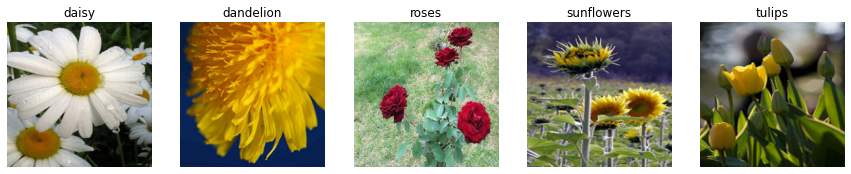

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt # plt 用于显示图片
import os
from PIL import Image # 用于读取图片

# 训练数据集目录
data_dir = "./dataset/case6/flowers/train"
flower_class = [cla for cla in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cla))]  #判断该路径是否为目录
flag = 0
# 显示图像及图像的类别
plt.figure(figsize=(15, 7))
for cla in flower_class:
    flag = flag+1
    cla_path = os.path.join(data_dir, cla)
    images = os.listdir(cla_path)
    index = random.sample(images, k=1)  #从每个类别中随机抽取一张图片
    for i, img in enumerate(images):
        plt.subplot(1, 5, flag)
        if img in index:
            image_path = os.path.join(cla_path, img)
            image = Image.open(image_path).convert("RGB")
            image = image.resize((224, 224))
            plt.imshow(image) # 显示图片
            plt.axis('off') # 不显示坐标轴
            plt.title(cla)
plt.show()

### 2.3 数据集加载

+ 数据集加载类函数**代码实现**如下：

> 可以通过设置num_worker数来调整处理器并行工作数量。

In [4]:
import multiprocessing

def get_num_parallel_workers(num_parallel_workers):
    """
    Get num_parallel_workers used in dataset operations.
    If num_parallel_workers > the real CPU cores number, set num_parallel_workers = the real CPU cores number.
    """
    cores = multiprocessing.cpu_count()
    if isinstance(num_parallel_workers, int):
        if cores < num_parallel_workers:
            print("The num_parallel_workers {} is set too large, now set it {}".format(num_parallel_workers, cores))
            num_parallel_workers = cores
    else:
        print("The num_parallel_workers {} is invalid, now set it {}".format(num_parallel_workers, min(cores, 8)))
        num_parallel_workers = min(cores, 8)
    return num_parallel_workers

+ 定义数据加载函数`create_dataset()`

In [5]:
import mindspore as ms
from mindspore.dataset.vision.c_transforms import RandomCropDecodeResize, RandomHorizontalFlip, Rescale, Normalize, HWC2CHW, CenterCrop
#所有C++实现的数据处理操作的基类以及所有Python实现的数据处理操作的基类。
import mindspore.dataset.transforms as ts
#此模块用于通用数据增强。
import mindspore.dataset as ds
#该模块提供了加载和处理各种通用数据集的API，如MNIST、CIFAR-10、CIFAR-100、VOC、COCO、ImageNet、CelebA、CLUE等。

def create_dataset(dataset_path, batch_size=8, train_image_size=224, do_train=False):
    """
    create a train or evaluate flowers dataset for resnet50
    Args:
        dataset_path(string): the path of dataset.
        do_train(bool): whether dataset is used for train or eval.
        batch_size(int): the batch size of dataset. Default: 8

    Returns:
        dataset
    """
    if do_train:
        trans = [RandomCropDecodeResize(size=(224, 224)), RandomHorizontalFlip(prob=0.5), Rescale(1.0 / 255.0, 0.0), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), HWC2CHW()]
    else:
        trans = [RandomCropDecodeResize(size=(256, 256)), CenterCrop(224), Rescale(1.0 / 255.0, 0.0), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), HWC2CHW()]
    type_cast_op = ts.c_transforms.TypeCast(ms.int32)
    dataset_loader = ds.ImageFolderDataset(dataset_dir=dataset_path)
    dataset_trans = dataset_loader.map(operations=trans, input_columns="image", num_parallel_workers=get_num_parallel_workers(8))
    dataset_trans = dataset_trans.map(operations=type_cast_op, input_columns="label", num_parallel_workers=get_num_parallel_workers(8))

    data_set = dataset_trans.batch(batch_size=batch_size, drop_remainder=True)

    return data_set

## 3、网络构建

### 3.1 网络参数设置

可以根据实际情况自行调整，具体含义如下：

+ 'netname': 网络名称

+ 'num_classes': 类别数量

+ 'data_path': 数据集路径

+ 'output_dir': 输出ckpt文件路径

+ 'epoch_size': 训练轮次

+ 'batch_size': 批量大小

+ 'optimizer': 优化器类型

+ 'pre_trained': 是否加载预训练模型

+ 'ckpt_path': ckpt路径

+ 'warmup_epochs': 启动训练轮次

+ 'lr_decay_mode': 学习率衰减方式

+ 'lr_init': 初始学习率

+ 'lr_end': 最小学习率

+ 'lr_max': 最大学习率

+ 'weight_decay': 权重衰减系数

+ 'momentum': 动量系数

+ 'loss_scale': 损失范围

+ 'boost_mode': boost模式训练等级。支持[”O0”,“O1”,“O2”]. 默认值:“O0”-不变化；"O1":启用boost模式，性能提升20%，准确率报保持不变；"O1":启用boost模式，性能提升30%，准确率下降小于3%。

+ 'run_eval': 是否验证

+ 'save_checkpoint': 是否保持ckpt文件

In [6]:

cfg = {
        'netname': 'resnet50',
        'num_classes': 5,
        'data_path': './dataset',
        'output_dir': './checkpoints',
        'epoch_size': epoch_size,
        'batch_size': batch_size,
        'optimizer': 'Momentum',
        'pre_trained': pre_trained,
        'ckpt_path': './checkpoints/pretrained.ckpt',
        'warmup_epochs': 0,
        'lr_decay_mode': 'poly',
        'lr_init': 0.01,
        'lr_end': 0.00001,
        'lr_max': 0.1,
        'weight_decay': 0.0001,
        'momentum': 0.9,
        'loss_scale': 1024.0,
        'boost_mode': "O0",
        'run_eval': True,
        'save_checkpoint': True
}

### 3.2 残差块实现

ResNet使用残差结构后可有效地减轻退化问题，实现更深的网络结构设计，提高网络的训练精度。残差块结构图如下图所示：

<div align="center">
<img src="./images/残差具体结构.png" width="15%" height="15%">
</div>

在实现残差块之前需要先定义一些关键函数，分别有`calculate_gain`、`_calculate_fan_in_and_fan_out`、`_calculate_correct_fan`、`kaiming_normal`、3×3卷积算子、`batchnormal`层以及1×1卷积。具体代码如下。

+ **calculate_gain**函数

作用：对于给定的非线性函数，返回推荐的增益值，用来调控输入数量级和输出数量级之间的关系**nonlinearity**为非线性激活函数

In [7]:
import math

def calculate_gain(nonlinearity, param=None):
    """calculate_gain"""
    linear_fns = ['linear', 'conv1d', 'conv2d', 'conv3d', 'conv_transpose1d', 'conv_transpose2d', 'conv_transpose3d']
    res = 0
    if nonlinearity in linear_fns or nonlinearity == 'sigmoid':
        res = 1
    elif nonlinearity == 'tanh':
        res = 5.0 / 3
    elif nonlinearity == 'relu':
        res = math.sqrt(2.0)
    elif nonlinearity == 'leaky_relu':
        if param is None:
            neg_slope = 0.01
        elif not isinstance(param, bool) and isinstance(param, int) or isinstance(param, float):
            neg_slope = param
        else:
            raise ValueError("neg_slope {} not a valid number".format(param))
        res = math.sqrt(2.0 / (1 + neg_slope ** 2))
    else:
        raise ValueError("Unsupported nonlinearity {}".format(nonlinearity))
    return res

+ **_calculate_fan_in_and_fan_out**函数

返回值由输入张量的维度决定

①如果输入的Tensor是2维的张量，则

$$fan\_in=in\_channels$$

$$fan\_out=out\_channels$$

②如果输入的是大于2维的张量，即经过卷积后得到的张量，则第一维作为out_channels，第二维作为in_channels，后两个维度为kernel_size，此时

$$fan\_in=in\_channels\times kernel\_size[0]\times kernel\_size[0]$$

$$fan\_out=out\_channels\times kernel\_size[0]\times kernel\_size[0]$$

In [8]:
def _calculate_fan_in_and_fan_out(tensor):
    """_calculate_fan_in_and_fan_out"""
    dimensions = len(tensor)
    if dimensions < 2:
        raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")
    if dimensions == 2:  # Linear
        fan_in = tensor[1]
        fan_out = tensor[0]
    else:
        num_input_fmaps = tensor[1]
        num_output_fmaps = tensor[0]
        receptive_field_size = 1
        if dimensions > 2:
            receptive_field_size = tensor[2] * tensor[3]
        fan_in = num_input_fmaps * receptive_field_size
        fan_out = num_output_fmaps * receptive_field_size
    return fan_in, fan_out


+ **_calculate_correct_fan**函数

作用：根据fan_mode返回相应的fan_in/fan_out

In [9]:
def _calculate_correct_fan(tensor, mode):
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError("Unsupported mode {}, please use one of {}".format(mode, valid_modes))
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == 'fan_in' else fan_out

+ **kaiming_normal**凯明正态分布初始化函数

① 采用**kaiming_normal**进行权重初始化，**kaiming_normal**是由何凯明于2015年提出的一种网络初始化的方法。[点击该连接了解更多原论文内容](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf)。其实现的是一种均值为0，方差为$std=\frac{gain}{\sqrt{fan\_mode}}$(非线性激活函数选择为ReLU)的正态分布

② **mode**可选择为**fan_in**或者**fan_out**。fan_in是在正向传播时保持方差一致，fan_out是在反向传播时保持方差一致

③ **a**是激活函数负半轴的斜率

In [10]:
import numpy as np

def kaiming_normal(inputs_shape, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(inputs_shape, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    return np.random.normal(0, std, size=inputs_shape).astype(np.float32)

+ 3×3卷积算子

In [11]:
import mindspore.nn as nn
from mindspore.common.tensor import Tensor

def _conv3x3(in_channel, out_channel, stride=1, res_base=False):

    weight_shape = (out_channel, in_channel, 3, 3)
    weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))
    if res_base:
        return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride,
                         padding=1, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride,
                     padding=0, pad_mode='same', weight_init=weight)

+ Batchnormal层定义

In [12]:
def _bn(channel, res_base=False):
    if res_base:
        return nn.BatchNorm2d(channel, eps=1e-5, momentum=0.1,
                              gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

+ 下采样层用到的1×1卷积算子定义

In [13]:
def _conv1x1(in_channel, out_channel, stride=1, use_se=False, res_base=False):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))
    if res_base:
        return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride,
                         padding=0, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride,
                     padding=0, pad_mode='same', weight_init=weight)

### 3.3 残差块具体实现

搭建瓶颈结构的残差块类`ResidualBlock`，为了方便理解我们将瓶颈结构的残差块示意图放在此处：

<div align="center">
<img src="./images/两种残差块的设计.png" width="30%" height="30%">
</div>

In [14]:
import mindspore.ops as ops
#导入用于Cell的构造函数的算子
class ResidualBlock(nn.Cell):
    """
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4

    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1,
                 use_se=False, se_block=False):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.use_se = use_se
        self.se_block = se_block
        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)

        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)

        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn(out_channel)
        self.relu = nn.ReLU()

        self.down_sample = False

        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None

        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride), _bn(out_channel)])

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.se_block:
            out_se = out
            out = self.se_global_pool(out, (2, 3))
            out = self.se_dense_0(out)
            out = self.relu(out)
            out = self.se_dense_1(out)
            out = self.se_sigmoid(out)
            out = ops.reshape(out, ops.shape(out) + (1, 1))
            out = self.se_mul(out, out_se)

        if self.down_sample:
            identity = self.down_sample_layer(identity)

        out = out + identity
        out = self.relu(out)

        return out


### 3.4 构建ResNet50网络

不同层数的ResNet网络整体结构框架如下图所示：

<div align="center">
<img src="./images/ResNet50网络整体结构框图.png" width="70%" height="70%">
</div>

可以看出网络是由残差块构建而成，在代码中残差块的堆叠操作是由`make_layer`函数实现的，只需要对应更改每一个残差块的输入输出通道数(in_channel & out_channel)以及堆叠的次数(layer_num)。其代码如下所示：

In [15]:
def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
    layers = []
    resnet_block = block(in_channel, out_channel, stride=stride)
    layers.append(resnet_block)
    for _ in range(1, layer_num):
        resnet_block = block(out_channel, out_channel, stride=1)
        layers.append(resnet_block)
    return nn.SequentialCell(layers)

不同层数的ResNet都是先通过了`7×7`的卷积，再通过`3×3`的最大池化操作，然后都设计有四个残差块，不同的是残差块的参数设置以及残差块结构不同。

在代码实现中因为残差跳跃连接部分必须保证所叠加的两个特征图的形状相同，通过观察ResNet50结构可以发现在conv2_1部分，经过`3×3`的最大池化操作后，特征图的形状为`56×56×64`而此时该残差块的输出特征图的形状为`56×56×256`，这两部分的通道数不同，如果使用实线的恒等映射连接则不能直接相加，为此还有一种虚线连接结构，也就是原论文提到的OptionB，其结构示意图如下图所示(以Conv2_1为例)。

在50/101/152层网络中的`conv2_1、conv3_1、conv4_1、conv5_1`都采用了虚线连接的结构，而在18/34层网络结构中`conv2_1`采用的还是实线恒等映射连接。

<div align="center">
<img src="./images/conv2_1结构示意图.png" width="70%" height="70%">
</div>

+ 网络第一层的7×7卷积算子

In [16]:
def _conv7x7(in_channel, out_channel, stride=1, res_base=False):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))
    if res_base:
        return nn.Conv2d(in_channel, out_channel,
                         kernel_size=7, stride=stride, padding=3, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)

+ kaiming_uniform凯明均匀分布初始化

In [17]:
def kaiming_uniform(inputs_shape, a=0., mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(inputs_shape, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    bound = math.sqrt(3.0) * std  # Calculate uniform bounds from standard deviation
    return np.random.uniform(-bound, bound, size=inputs_shape).astype(np.float32)

+ 定义全连接层

In [18]:
def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = Tensor(kaiming_uniform(weight_shape, a=math.sqrt(5)))
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

+ 定义残差网络

In [19]:
class ResNet(nn.Cell):
    """
    ResNet architecture.
    Returns:
        Tensor, output tensor.
    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        [1, 2, 2, 2],
        >>>        10)
    """

    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes, res_base=False):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")
        self.res_base = res_base

        self.conv1 = _conv7x7(3, 64, stride=2, res_base=self.res_base)
        self.bn1 = _bn(64, self.res_base)
        self.relu = ops.ReLU()

        if self.res_base:
            self.pad = nn.Pad(paddings=((0, 0), (0, 0), (1, 1), (1, 1)))
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="valid")
        else:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block, layer_nums[0], in_channel=in_channels[0], out_channel=out_channels[0], stride=strides[0])
        self.layer2 = self._make_layer(block, layer_nums[1], in_channel=in_channels[1], out_channel=out_channels[1], stride=strides[1])
        self.layer3 = self._make_layer(block, layer_nums[2], in_channel=in_channels[2], out_channel=out_channels[2], stride=strides[2])
        self.layer4 = self._make_layer(block, layer_nums[3], in_channel=in_channels[3], out_channel=out_channels[3], stride=strides[3])

        self.mean = ops.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        layers = []
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)
        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)
        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.res_base:
            x = self.pad(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return out

+ ResNet50网络具体构建代码如下：

从ResNet50的网络结构中可以看出，每一层使用的残差块的数量分别为3、4、6、3，每一层输入的通道数分别为64、256、512、1024，每一层输出通道数分别为256、512、1024、2048。具体分析如下：

<div align="center">
<img src="./images/ResNet50网络结构分析.png" width="80%" height="60%">
</div>

In [20]:
def resnet50(class_num=5):
    """
    Returns:
        Cell, cell instance of ResNet50 neural network.

    Examples:
        >>> net = resnet50(10)
    """
    return ResNet(ResidualBlock, layer_nums=[3, 4, 6, 3], in_channels=[64, 256, 512, 1024], out_channels=[256, 512, 1024, 2048], strides=[1, 2, 2, 2], num_classes=class_num)

## 4、网络训练

### 4.1 训练过程

+ 定义加载预训练权重函数

In [21]:
import glob
#用于返回所有匹配的文件路径列表
import mindspore.log as logger
import datetime
#用于获取当前时间

def load_pre_trained_checkpoint():
    param_dict = None
    if cfg['pre_trained']:
        if os.path.isdir(cfg['ckpt_path']):
            ckpt_save_dir = cfg['ckpt_path']
            ckpt_pattern = os.path.join(ckpt_save_dir, "*.ckpt")
            ckpt_files = glob.glob(ckpt_pattern)
            if not ckpt_files:
                logger.warning(f"There is no ckpt file in {ckpt_save_dir}, "
                               f"pre_trained is unsupported.")
            else:
                ckpt_files.sort(key=os.path.getmtime, reverse=True)
                time_stamp = datetime.datetime.now()
                print(f"time stamp {time_stamp.strftime('%Y.%m.%d-%H:%M:%S')}"
                      f" pre trained ckpt model {ckpt_files[0]} loading",
                      flush=True)
                param_dict = ms.load_checkpoint(ckpt_files[0])
        elif os.path.isfile(cfg['ckpt_path']):
            param_dict = ms.load_checkpoint(cfg['ckpt_path'])
            print('Successfully loaded!')
        else:
            print(f"Invalid pre_trained {cfg['ckpt_path']} parameter.")
    return param_dict

+ 加载预训练权重参数

In [22]:
if cfg['pre_trained']:
    ckpt_param_dict = load_pre_trained_checkpoint()

Successfully loaded!


+ 加载训练数据集

In [23]:
dataset = create_dataset(dataset_path=os.path.join(cfg['data_path'], 'case6', 'flowers', 'train'), batch_size=cfg['batch_size'], do_train=True)
step_size = dataset.get_dataset_size()

+ 加载验证数据集

In [24]:
ds_val = create_dataset(dataset_path=os.path.join(cfg['data_path'], 'case6', 'flowers', 'val'))

+ 加载网络模型

In [25]:
net = resnet50(class_num=cfg['num_classes'])

+ 网络权重初始化：加载预训练权重

In [26]:
if cfg['pre_trained']:
    ms.load_param_into_net(net, ckpt_param_dict)

+ 学习率调整策略选用Poly策略

In [27]:
def _generate_poly_lr(lr_init, lr_end, lr_max, total_steps, warmup_steps):
    lr_each_step = []
    if warmup_steps != 0:
        inc_each_step = (float(lr_max) - float(lr_init)) / float(warmup_steps)
    else:
        inc_each_step = 0
    for i in range(total_steps):
        if i < warmup_steps:
            lr = float(lr_init) + inc_each_step * float(i)
        else:
            base = (1.0 - (float(i) - float(warmup_steps)) / (float(total_steps) - float(warmup_steps)))
            lr = float(lr_max) * base * base
            if lr < 0.0:
                lr = 0.0
        lr_each_step.append(lr)
    return lr_each_step

+ 设置学习率

In [28]:
def get_lr(lr_init, lr_end, lr_max, warmup_epochs, total_epochs, steps_per_epoch, lr_decay_mode):
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    lr_each_step = _generate_poly_lr(lr_init, lr_end, lr_max, total_steps, warmup_steps)
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    return lr_each_step

+ 初始化学习率

In [29]:
def init_lr(step_size):
    """init lr"""
    if cfg['netname'] in ("resnet18", "resnet34", "resnet50", "resnet152", "se-resnet50"):
        lr = get_lr(lr_init=cfg['lr_init'], lr_end=cfg['lr_end'], lr_max=cfg['lr_max'], warmup_epochs=cfg['warmup_epochs'], total_epochs=cfg['epoch_size'], steps_per_epoch=step_size, lr_decay_mode=cfg['lr_decay_mode'])
    return lr

lr = ms.Tensor(init_lr(step_size=step_size))

+ 优化器参数设置

In [30]:
def init_group_params(net):
    decayed_params = []
    no_decayed_params = []
    for param in net.trainable_params():
        if 'beta' not in param.name and 'gamma' not in param.name and 'bias' not in param.name:
            decayed_params.append(param)
        else:
            no_decayed_params.append(param)

    group_params = [{'params': decayed_params, 'weight_decay': cfg['weight_decay']},
                    {'params': no_decayed_params},
                    {'order_params': net.trainable_params()}]
    return group_params

group_params = init_group_params(net)
opt = nn.Momentum(group_params, lr, cfg['momentum'], loss_scale=cfg['loss_scale'])

+ 设置损失缩放系数不变的管理器

In [31]:
def init_loss_scale():
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    return loss

loss = init_loss_scale()
loss_scale = ms.FixedLossScaleManager(cfg['loss_scale'], drop_overflow_update=False)

+ 加载模型

In [32]:
metrics = {"acc"}

if (cfg['netname'] not in ("resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "se-resnet50")) or \
    context.get_context("device_target") == "CPU":
    ## fp32 training
    model = ms.Model(net, loss_fn=loss, optimizer=opt, metrics=metrics, eval_network=None)
else:
    model = ms.Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics=metrics, amp_level="O3", boost_level=cfg['boost_mode'], keep_batchnorm_fp32=False, eval_network=None)

+ 设置损失回调函数

In [33]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

class LossCallBack(LossMonitor):
    """
    Monitor the loss in training.
    If the loss in NAN or INF terminating training.
    """

    def __init__(self, has_trained_epoch=0, per_print_times=per_print_steps):
        super(LossCallBack, self).__init__()
        self.has_trained_epoch = has_trained_epoch
        self._per_print_times = per_print_times

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        if isinstance(loss, (tuple, list)):
            if isinstance(loss[0], ms.Tensor) and isinstance(loss[0].asnumpy(), np.ndarray):
                loss = loss[0]

        if isinstance(loss, ms.Tensor) and isinstance(loss.asnumpy(), np.ndarray):
            loss = np.mean(loss.asnumpy())

        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1

        if isinstance(loss, float) and (np.isnan(loss) or np.isinf(loss)):
            raise ValueError("epoch: {} step: {}. Invalid loss, terminating training.".format(
                cb_params.cur_epoch_num, cur_step_in_epoch))
        if self._per_print_times != 0 and cb_params.cur_step_num % self._per_print_times == 0:
            # pylint: disable=line-too-long
            print("epoch: %s step: %s, loss is %s" % (cb_params.cur_epoch_num + int(self.has_trained_epoch),
                                                      cur_step_in_epoch, loss), flush=True)

time_cb = TimeMonitor(data_size=step_size)
loss_cb = LossCallBack(has_trained_epoch=0)

cb = [time_cb, loss_cb]
ckpt_save_dir = cfg['output_dir']
device_target = context.get_context('device_target')

if cfg['save_checkpoint']:
    config_ck = CheckpointConfig(save_checkpoint_steps=save_ckpt_num*step_size, keep_checkpoint_max=10)
    # config_ck = CheckpointConfig(save_checkpoint_steps=5*step_size, keep_checkpoint_max=10)
    ckpt_cb = ModelCheckpoint(prefix="resnet", directory=ckpt_save_dir, config=config_ck)
    cb += [ckpt_cb]

+ 模型训练

In [34]:
print("============== Starting Training ==============")
model.train(cfg['epoch_size'], dataset, callbacks=cb, sink_size=dataset.get_dataset_size(), dataset_sink_mode=dataset_sink_mode)
print("============== Training Ended==============")

============== Starting Training ==============
epoch: 1 step: 200, loss is 0.6818447
epoch: 1 step: 400, loss is 1.2154493
epoch: 1 step: 600, loss is 0.8549518
epoch: 1 step: 800, loss is 0.34917742
epoch: 1 step: 1000, loss is 2.101867
epoch: 1 step: 1200, loss is 1.0080271
epoch: 1 step: 1400, loss is 1.1884489
epoch: 1 step: 1600, loss is 2.2717247
epoch time: 1215534.488 ms, per step time: 735.351 ms
============== Training Ended==============


### 4.2 可视化推理结果

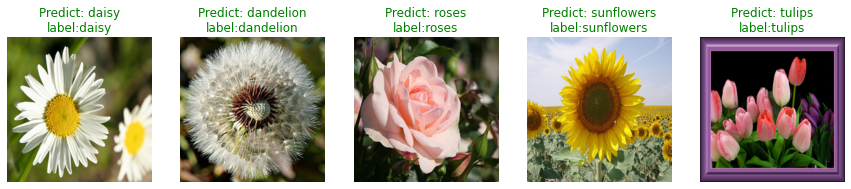

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import mindspore as ms

# best_ckpt_path = fixme_1
best_ckpt_path = r"./checkpoints/pretrained.ckpt"
# network = resnet50(class_num=fixme_2)
network = resnet50(class_num=5)

# 定义可视化函数
def visualize_model(image_path, label, ckpt_path=best_ckpt_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = network
    param_dict = ms.load_checkpoint(ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)

    # 模型预测
    pre = model.predict(ms.Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "daisy", 1: "dandelion", 2: "roses", 3: "sunflowers", 4: "tulips"}
    color = 'green' if class_name[result] == label else 'red'

    plt.title(f"Predict: {class_name[result]}\nlabel:{label}", color=color)
    plt.axis("off")
    return result

image1 = "./dataset/case6/flowers/infer/daisy.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 5, 1)
visualize_model(image1, "daisy")

image2 = "./dataset/case6/flowers/infer/dandelion.jpg"
plt.subplot(1, 5, 2)
visualize_model(image2, "dandelion")

image3 = "./dataset/case6/flowers/infer/roses.jpg"
plt.subplot(1, 5, 3)
visualize_model(image3, "roses")

image4 = "./dataset/case6/flowers/infer/sunflowers.jpg"
plt.subplot(1, 5, 4)
visualize_model(image4, "sunflowers")

image5 = "./dataset/case6/flowers/infer/tulips.jpg"
plt.subplot(1, 5, 5)
visualize_model(image5, "tulips")

plt.show()

## 5、实验任务与参考解答

### 5.1 实验任务

将可视化代码中fixme的地方进行相应的修改以至代码可以顺利运行。

### 5.2 参考解答

</details>
<details><summary>
    点击显示答案
    </summary>

  + fixme_1：./checkpoints/你的本地训练结果.ckpt

  + fixme_2：5

</details>